**In this notebook we use PyCaret to quickly compare the efficacy CML models to predict cloud cover**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import xarray as xr

Open the data

In [2]:
# define a function that opens the data file and returns the data
def open_data(data_dir):
    # open the data file
    era5 = xr.open_dataset(data_dir+'era5_data.nc')
    era5_single_lvl = xr.open_dataset(data_dir+'era5_single_levels.nc')
    goes_cod = xr.open_dataset(data_dir+'GOESDataUpdated/CloudOpticalDepth_remapped.nc')
    goes_ctt = xr.open_dataset(data_dir+'GOESDataUpdated/CloudTopTemperature_remapped.nc')
    goes_dsw = xr.open_dataset(data_dir+'GOESDataUpdated/DownwardSW_remapped.nc')
    goes_rsw = xr.open_dataset(data_dir+'GOESDataUpdated/ReflectedSW_remapped.nc')
    goes_tpw = xr.open_dataset(data_dir+'GOESDataUpdated/TotalPrecipWater_remapped.nc')
    # return the dataframes
    return era5, era5_single_lvl, goes_cod, goes_ctt, goes_dsw, goes_rsw, goes_tpw

In [3]:
# SET YOU OWN DATA DIRECTORY HERE
data_dir = '/Users/ionph/MLdata/'
# call the function to open the data
era5, era5_single_lvl, goes_cod, goes_ctt, goes_dsw, goes_rsw, goes_tpw = open_data(data_dir)

In [4]:
era5

<xarray.Dataset>
Dimensions:         (valid_time: 1650, pressure_level: 2, latitude: 41,
                     longitude: 81)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2014-04-01T13:00:00 ... 2024-...
  * pressure_level  (pressure_level) float64 950.0 700.0
  * latitude        (latitude) float64 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude       (longitude) float64 -65.0 -64.75 -64.5 ... -45.25 -45.0
Data variables:
    number          int64 ...
    expver          (valid_time) object ...
    cc              (valid_time, pressure_level, latitude, longitude) float32 ...
    r               (valid_time, pressure_level, latitude, longitude) float32 ...
    clwc            (valid_time, pressure_level, latitude, longitude) float32 ...
    t               (valid_time, pressure_level, latitude, longitude) float32 ...
    u               (valid_time, pressure_level, latitude, longitude) float32 ...
    v               (valid_time, pressure_level, latitude, longitude) float32 ...
    w               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:01 GRIB to CDM+CF via cfgrib-0.9.1...

Clean the data to be stored in one large dataframe

In [5]:
# select the data in era5 from 2020
era5_2020 = era5.sel(valid_time=slice('2020-01-01', '2020-12-31'))
# select the data only at 15 UTC
era5_2020 = era5_2020.sel(valid_time=era5_2020.valid_time.dt.hour==15)

# to the same for the single level data
era5_single_lvl_2020 = era5_single_lvl.sel(valid_time=slice('2020-01-01', '2020-12-31'))
era5_single_lvl_2020 = era5_single_lvl_2020.sel(valid_time=era5_single_lvl_2020.valid_time.dt.hour==15)

# separate the era5 data into 950 hPa and 700 hPa
era5_950 = era5_2020.sel(pressure_level=950, method='nearest')
era5_700 = era5_2020.sel(pressure_level=700, method='nearest')

# drop the expver and number coordinates from the era5_single_lvl data
era5_single_lvl_2020 = era5_single_lvl_2020.drop(['expver', 'number'])

# drop the pressure_level coordinate from the era5 data
era5_950 = era5_950.drop('pressure_level')
era5_700 = era5_700.drop('pressure_level')

# replace the era5 valid_time coordinate to the 'time' coordinates from goes data
era5_950 = era5_950.rename({'valid_time': 'time'})
era5_700 = era5_700.rename({'valid_time': 'time'})
era5_single_lvl_2020 = era5_single_lvl_2020.rename({'valid_time': 'time'})

# change the 'time' coordinates of the era5 data to match the goes data
era5_950['time'] = goes_cod['time']
era5_700['time'] = goes_cod['time']
era5_single_lvl_2020['time'] = goes_cod['time']

In [6]:
era5_950

<xarray.Dataset>
Dimensions:    (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time       (time) int64 92 93 94 95 96 97 98 ... 115 116 117 118 119 120 121
  * latitude   (latitude) float64 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 -65.0 -64.75 -64.5 ... -45.5 -45.25 -45.0
Data variables:
    number     int64 ...
    expver     (time) object ...
    cc         (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    clwc       (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    w          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:01 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
goes_cod

<xarray.Dataset>
Dimensions:            (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time               (time) int64 92 93 94 95 96 97 ... 117 118 119 120 121
  * latitude           (latitude) float64 20.0 20.25 20.5 ... 29.5 29.75 30.0
  * longitude          (longitude) float64 -65.0 -64.75 -64.5 ... -45.25 -45.0
Data variables:
    CloudOpticalDepth  (time, latitude, longitude) float64 ...
Attributes:
    title:        Cloud Optical Depth Remapped
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

Convert the datasets into Pandas dataframes

In [8]:
df_r_950 = era5_950['r'].to_dataframe().reset_index()
df_r_700 = era5_700['r'].to_dataframe().reset_index()
df_clwc_950 = era5_950['clwc'].to_dataframe().reset_index()
df_clwc_700 = era5_700['clwc'].to_dataframe().reset_index()
df_cc_950 = era5_950['cc'].to_dataframe().reset_index()
df_cc_700 = era5_700['cc'].to_dataframe().reset_index()
df_t_950 = era5_950['t'].to_dataframe().reset_index()
df_t_700 = era5_700['t'].to_dataframe().reset_index()
df_u_950 = era5_950['u'].to_dataframe().reset_index()
df_u_700 = era5_700['u'].to_dataframe().reset_index()
df_v_950 = era5_950['v'].to_dataframe().reset_index()
df_v_700 = era5_700['v'].to_dataframe().reset_index()
df_w_950 = era5_950['w'].to_dataframe().reset_index()
df_w_700 = era5_700['w'].to_dataframe().reset_index()
df_u10 = era5_single_lvl_2020['u10'].to_dataframe().reset_index()
df_v10 = era5_single_lvl_2020['v10'].to_dataframe().reset_index()
df_t2m = era5_single_lvl_2020['t2m'].to_dataframe().reset_index()
df_sst = era5_single_lvl_2020['sst'].to_dataframe().reset_index()
df_slhf = era5_single_lvl_2020['slhf'].to_dataframe().reset_index()
df_sshf = era5_single_lvl_2020['sshf'].to_dataframe().reset_index()
df_hcc = era5_single_lvl_2020['hcc'].to_dataframe().reset_index()
df_lcc = era5_single_lvl_2020['lcc'].to_dataframe().reset_index()
df_tcc = era5_single_lvl_2020['tcc'].to_dataframe().reset_index()
df_goes_cod = goes_cod.to_dataframe().reset_index()
df_goes_ctt = goes_ctt.to_dataframe().reset_index()
df_goes_dsw = goes_dsw.to_dataframe().reset_index()
df_goes_rsw = goes_rsw.to_dataframe().reset_index()
df_goes_tpw = goes_tpw.to_dataframe().reset_index()

dfs = [df_r_950, df_r_700, df_clwc_950, df_clwc_700, df_cc_950, df_cc_700, df_t_950, df_t_700, df_u_950, df_u_700, df_v_950, df_v_700, df_w_950, df_w_700, df_u10, df_v10, df_t2m, df_sst, df_slhf, df_sshf, df_hcc, df_lcc, df_tcc, df_goes_cod, df_goes_ctt, df_goes_dsw, df_goes_rsw, df_goes_tpw]

Merge the dataframes into one dataframe

In [9]:
# merge all of the dataframes in dfs
df = pd.merge(dfs[0], dfs[1], on=['time', 'latitude', 'longitude'], suffixes=('_950', '_700'))
for i in range(2, len(dfs)):
    df = pd.merge(df, dfs[i], on=['time', 'latitude', 'longitude'])

# change the column names with suffix "_x" to "_950" and "_y" to "_700"
df.columns = df.columns.str.replace('_x', '_950')
df.columns = df.columns.str.replace('_y', '_700')

In [10]:
df.columns

Index(['time', 'latitude', 'longitude', 'r_950', 'r_700', 'clwc_950',
       'clwc_700', 'cc_950', 'cc_700', 't_950', 't_700', 'u_950', 'u_700',
       'v_950', 'v_700', 'w_950', 'w_700', 'u10', 'v10', 't2m', 'sst', 'slhf',
       'sshf', 'hcc', 'lcc', 'tcc', 'CloudOpticalDepth', 'CloudTopTemperature',
       'DownwardSW', 'ReflectedSW', 'TotalPrecipWater'],
      dtype='object')

Drop columns that won't be used for prediction

In [11]:
from sklearn.model_selection import train_test_split

# Define features for analysis
features = df.drop(['time','latitude', 'longitude'], axis=1)

# Split the data into training and testing sets
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42)

In [12]:
from pycaret.regression import *
exp_reg101 = setup(data = train_data, 
                   target = 'tcc',
                   # imputation_type='iterative', 
                   fold_shuffle=True, 
                   session_id=123)

,Description,Value
0,Session id,123
1,Target,tcc
2,Target type,Regression
3,Original data shape,"(79704, 28)"
4,Transformed data shape,"(79704, 28)"
5,Transformed train set shape,"(55792, 28)"
6,Transformed test set shape,"(23912, 28)"
7,Numeric features,27
8,Rows with missing values,95.6%
9,Preprocess,True


In [15]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0218,0.0019,0.0439,0.9804,0.0302,0.1136,11.2610
xgboost,Extreme Gradient Boosting,0.0245,0.0020,0.0444,0.9800,0.0306,0.1659,0.5540
rf,Random Forest Regressor,0.0235,0.0023,0.0481,0.9765,0.0331,0.1220,31.0260
lightgbm,Light Gradient Boosting Machine,0.0256,0.0024,0.0487,0.9759,0.0337,0.1774,0.4540
gbr,Gradient Boosting Regressor,0.0352,0.0041,0.0641,0.9583,0.0443,0.3167,11.6530
dt,Decision Tree Regressor,0.0314,0.0048,0.0693,0.9512,0.0481,0.1457,0.7070
ridge,Ridge Regression,0.0757,0.0116,0.1075,0.8826,0.0693,1.3474,0.0530
lar,Least Angle Regression,0.0804,0.0135,0.1164,0.8626,0.0738,1.1195,0.0540
ada,AdaBoost Regressor,0.1312,0.0228,0.1508,0.7687,0.1135,3.0292,3.8630
lr,Linear Regression,0.1196,0.0273,0.1611,0.7238,0.1064,2.0654,0.0560


In [16]:
best

ExtraTreesRegressor(n_jobs=-1, random_state=123)

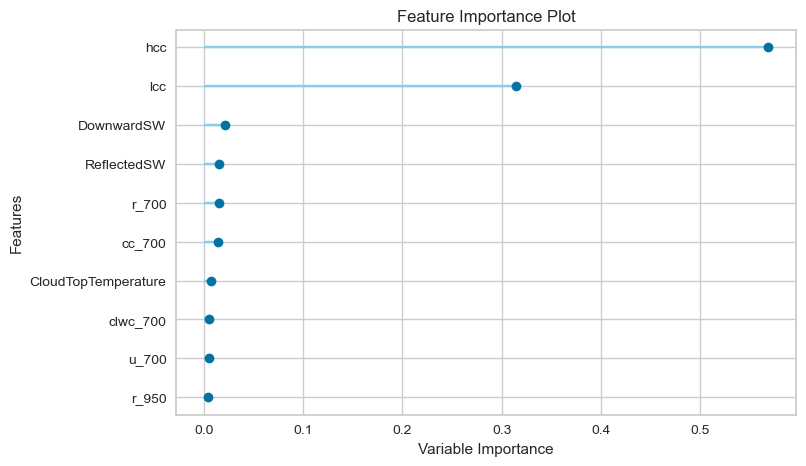

In [17]:
plot_model(best, plot = 'feature')

It is clear that the cloud cover variables (hcc, lcc, cc_700) are the best predictors of the total cloud cover, which is obvious because they are components of the total. However, if we remove these from our training data, how does that change the performance of the model and what features become the new best predictors of total cloud cover?

In [18]:
# create a new dataset from the features dataframe, but remove the "cc" variables
features_no_cc = features.drop(['cc_950', 'cc_700','hcc','lcc'], axis=1)
# show the updated features
features_no_cc.columns

Index(['r_950', 'r_700', 'clwc_950', 'clwc_700', 't_950', 't_700', 'u_950',
       'u_700', 'v_950', 'v_700', 'w_950', 'w_700', 'u10', 'v10', 't2m', 'sst',
       'slhf', 'sshf', 'tcc', 'CloudOpticalDepth', 'CloudTopTemperature',
       'DownwardSW', 'ReflectedSW', 'TotalPrecipWater'],
      dtype='object')

Perform the same analysis from before.

In [20]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(features_no_cc, test_size=0.2, random_state=42)

In [21]:
from pycaret.regression import *
exp_reg101 = setup(data = train_data, 
                   target = 'tcc',
                   # imputation_type='iterative', 
                   fold_shuffle=True, 
                   session_id=124)

,Description,Value
0,Session id,124
1,Target,tcc
2,Target type,Regression
3,Original data shape,"(79704, 24)"
4,Transformed data shape,"(79704, 24)"
5,Transformed train set shape,"(55792, 24)"
6,Transformed test set shape,"(23912, 24)"
7,Numeric features,23
8,Rows with missing values,95.6%
9,Preprocess,True


In [22]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0885,0.0143,0.1195,0.8552,0.0831,1.2323,9.0600
rf,Random Forest Regressor,0.1011,0.0187,0.1366,0.8109,0.0950,1.5596,26.2650
xgboost,Extreme Gradient Boosting,0.1218,0.0254,0.1594,0.7426,0.1108,1.8252,0.4990
lightgbm,Light Gradient Boosting Machine,0.1475,0.0350,0.1871,0.6455,0.1298,2.6434,0.4340
dt,Decision Tree Regressor,0.1315,0.0428,0.2068,0.5667,0.1434,1.6111,0.5980
gbr,Gradient Boosting Regressor,0.1813,0.0505,0.2248,0.4881,0.1552,3.4362,10.9730
lr,Linear Regression,0.2076,0.0637,0.2523,0.3552,0.1736,4.0838,0.0510
ridge,Ridge Regression,0.2076,0.0637,0.2523,0.3552,0.1736,4.0839,0.0460
ada,AdaBoost Regressor,0.2229,0.0663,0.2574,0.3286,0.1802,5.1275,2.0860
en,Elastic Net,0.2272,0.0734,0.2709,0.2568,0.1860,4.8821,0.1670


In [23]:
best

ExtraTreesRegressor(n_jobs=-1, random_state=124)

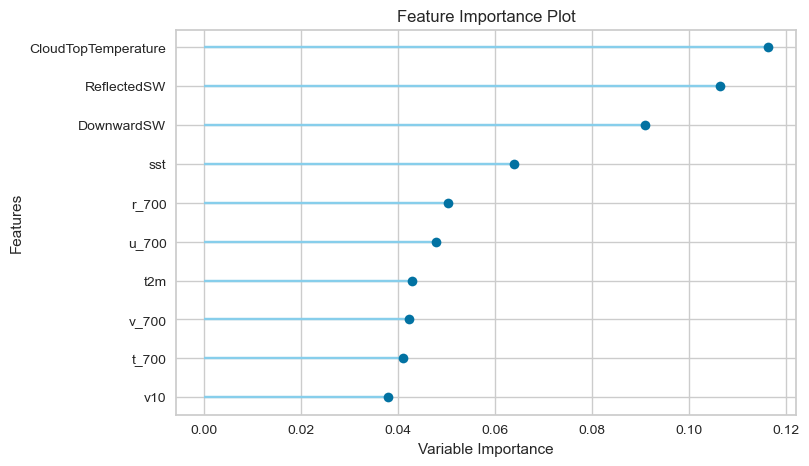

In [24]:
plot_model(best, plot = 'feature')

As seen in the plot above, cloud top temperature and Reflected SW are the best predictors of cloud cover. While we expect reflected SW to be a strong predictor of cloud cover (SW radiation is reflected by clouds), it is somewhat unexpected to see cloud top temperature as a predictor for cloud cover. It may be that the cloud top temperature data is only above 0 or NaN when a cloud is actually present, which can be used as an indicator of cloud cover, but the actual temperature may not dictate the cover of clouds. Additionally, we see that time is a fair predictor of cloud cover, meaning that there is a strong correlation in the data between the date and the total cloud cover. This tells us that the day-to-day cloudiness is being considered by the model, suggesting that we do not have a sufficient number of days in our dataset.

To compare the ability of CML models to the deep learning models used later in the project, we modify the problem to be a binary classification. Here tcc of greater than 0.5 is considered cloudy and is denoted as "1" and tcc less than 0.5 is considered clear denoted as "0". Below we add another feature to reflect this class then predict using it.

In [31]:
features_no_cc.columns
# add a new column to the dataframe that classifies the data points as either 1 for cloudy or or 0 for clear
features_no_cc['class'] = np.where((features_no_cc['tcc'] > 0.5), 1, 0)
# drop "tcc" from the dataframe so it is not used to predict the class
features_no_cc = features_no_cc.drop('tcc', axis=1)
# show the updated dataframe
features_no_cc.columns

Index(['r_950', 'r_700', 'clwc_950', 'clwc_700', 't_950', 't_700', 'u_950',
       'u_700', 'v_950', 'v_700', 'w_950', 'w_700', 'u10', 'v10', 't2m', 'sst',
       'slhf', 'sshf', 'CloudOpticalDepth', 'CloudTopTemperature',
       'DownwardSW', 'ReflectedSW', 'TotalPrecipWater', 'class'],
      dtype='object')

In [33]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(features_no_cc, test_size=0.2, random_state=42)

In [34]:
from pycaret.classification import *
exp_reg101 = setup(data = train_data, 
                   target = 'class',
                   # imputation_type='iterative', 
                   fold_shuffle=True, 
                   session_id=125)

,Description,Value
0,Session id,125
1,Target,class
2,Target type,Binary
3,Original data shape,"(79704, 24)"
4,Transformed data shape,"(79704, 24)"
5,Transformed train set shape,"(55792, 24)"
6,Transformed test set shape,"(23912, 24)"
7,Numeric features,23
8,Rows with missing values,95.6%
9,Preprocess,True


In [35]:
best = compare_models(exclude = ['ransac'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9163,0.9730,0.8586,0.9203,0.8883,0.8215,0.8228,2.2010
rf,Random Forest Classifier,0.9023,0.9651,0.8263,0.9137,0.8678,0.7907,0.7932,5.1920
xgboost,Extreme Gradient Boosting,0.8733,0.9421,0.7865,0.8744,0.8281,0.7282,0.7308,0.4150
lightgbm,Light Gradient Boosting Machine,0.8348,0.9123,0.7108,0.8389,0.7695,0.6422,0.6476,0.5690
dt,Decision Tree Classifier,0.8326,0.8241,0.7860,0.7834,0.7847,0.6478,0.6478,0.6420
gbc,Gradient Boosting Classifier,0.7837,0.8469,0.6047,0.7887,0.6845,0.5243,0.5351,11.4710
ada,Ada Boost Classifier,0.7620,0.8176,0.5781,0.7512,0.6533,0.4768,0.4863,2.3860
lda,Linear Discriminant Analysis,0.7461,0.7900,0.5175,0.7507,0.6126,0.4331,0.4497,0.0780
ridge,Ridge Classifier,0.7430,0.7852,0.5097,0.7477,0.6062,0.4254,0.4427,0.0500
qda,Quadratic Discriminant Analysis,0.7268,0.7769,0.4679,0.7314,0.5706,0.3842,0.4049,0.0950


In [36]:
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=125, verbose=0,
                     warm_start=False)

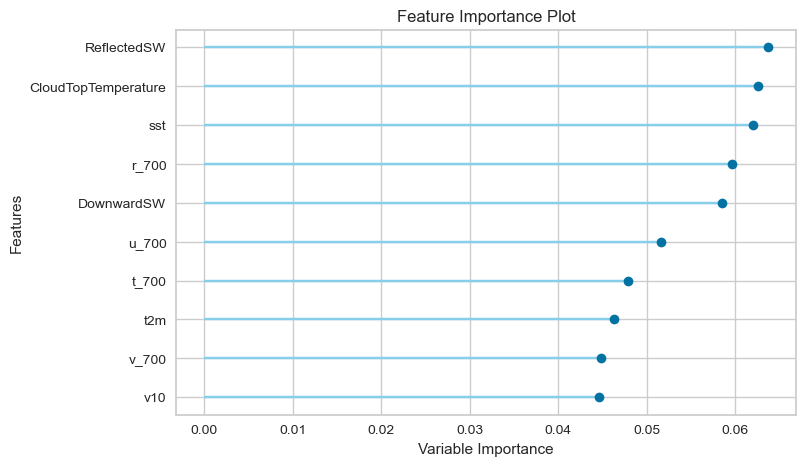

In [37]:
plot_model(best, plot = 'feature')

In [38]:
predictions = predict_model(best, data=test_data)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9204,0.9755,0.8727,0.9189,0.8952,0.8310,0.8318


,r_950,r_700,clwc_950,clwc_700,t_950,t_700,u_950,u_700,v_950,v_700,...,slhf,sshf,CloudOpticalDepth,CloudTopTemperature,DownwardSW,ReflectedSW,TotalPrecipWater,class,prediction_label,prediction_score
2360,77.013626,16.019842,0.000000,0.000000,292.121582,281.188965,3.015274,5.812286,5.867477,4.870071,...,-591817.0,-27622.0,NaN,NaN,920.532593,146.594666,NaN,0,0,0.83
28413,87.331970,87.834846,0.000000,0.000058,290.551758,274.831543,-1.368423,12.117737,3.275528,5.432648,...,-229701.0,-21617.0,1.230847,291.628998,947.932251,141.030045,29.922123,0,0,0.86
8309,84.810623,14.944800,0.000000,0.000000,291.822754,279.313477,7.184265,11.737305,10.302628,7.227875,...,-495319.0,13465.0,NaN,NaN,993.071899,111.758728,21.233490,0,0,0.95
58789,81.259750,8.376956,0.000000,0.000000,290.475586,281.708496,-5.585831,-1.737228,-0.582489,-0.640167,...,-582222.0,-35960.0,NaN,NaN,1028.895142,94.727600,20.291275,0,0,0.96
73237,95.162918,8.702097,0.000021,0.000000,287.721069,277.818604,-6.497360,9.628052,-5.965393,-0.542496,...,-384538.0,-33617.0,NaN,NaN,951.091064,130.287643,20.725439,1,1,0.56


In [ ]:
# add a new column to the dataframe that classifies the data points as either 1 for cloudy or or 0 for clear
df['class'] = np.where((df['tcc'] > 0.5), 1, 0)
# drop "tcc" from the dataframe so it is not used to predict the class
df = df.drop(['tcc','hcc','lcc','cc_950','cc_700'], axis=1)

predictions_time = predict_model(best, data=df)
predictions_time.head()

,time,latitude,longitude,r_950,r_700,clwc_950,clwc_700,t_950,t_700,u_950,...,slhf,sshf,CloudOpticalDepth,CloudTopTemperature,DownwardSW,ReflectedSW,TotalPrecipWater,class,prediction_label,prediction_score
0,92,30.0,-65.00,85.720657,22.269842,0.0,0.0,291.174316,278.603027,12.698868,...,-699337.0,5658.0,NaN,NaN,NaN,NaN,NaN,1,1,1.00
1,92,30.0,-64.75,86.595657,20.168280,0.0,0.0,291.072754,278.698730,12.353165,...,-718089.0,-2214.0,NaN,NaN,NaN,NaN,NaN,1,1,1.00
2,92,30.0,-64.50,87.349564,18.664373,0.0,0.0,291.006348,278.774902,11.919571,...,-690633.0,-5094.0,NaN,NaN,NaN,NaN,NaN,1,1,1.00
3,92,30.0,-64.25,87.224564,17.554998,0.0,0.0,290.953613,278.829590,11.460587,...,-656777.0,-5670.0,NaN,NaN,NaN,NaN,NaN,1,1,0.94
4,92,30.0,-64.00,86.521439,16.769842,0.0,0.0,290.893066,278.866699,10.946915,...,-614665.0,-2342.0,NaN,NaN,NaN,NaN,NaN,1,1,1.00


In [147]:
# select the data in predictions_time that have time = 92
predictions_time_92 = predictions_time[predictions_time['time'] == 92]
# select the data in predictions_time that have time = 93
predictions_time_93 = predictions_time[predictions_time['time'] == 93]


In [148]:
df_actual = predictions_time_92[['latitude', 'longitude', 'class']]
df_pred = predictions_time_92[['latitude', 'longitude', 'prediction_label']]

df_actual_93 = predictions_time_93[['latitude', 'longitude', 'class']]
df_pred_93 = predictions_time_93[['latitude', 'longitude', 'prediction_label']]

In [149]:
# reshape the class column to match the shape of the latitude and longitude columns
df_actual = df_actual.pivot(index='latitude', columns='longitude', values='class')
df_pred = df_pred.pivot(index='latitude', columns='longitude', values='prediction_label')
df_actual_93 = df_actual_93.pivot(index='latitude', columns='longitude', values='class')
df_pred_93 = df_pred_93.pivot(index='latitude', columns='longitude', values='prediction_label')
# make the latitude index descending
df_actual = df_actual.sort_index(ascending=False)
df_pred = df_pred.sort_index(ascending=False)
df_actual_93 = df_actual_93.sort_index(ascending=False)
df_pred_93 = df_pred_93.sort_index(ascending=False)


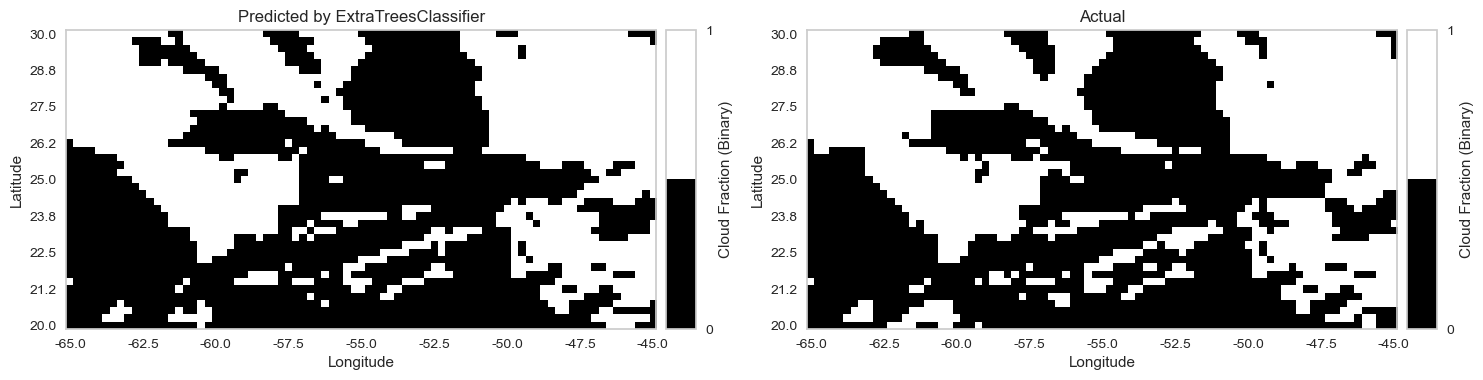

In [152]:
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define a binary colormap (black for 0, white for 1)
binary_cmap = mcolors.ListedColormap(['black', 'white'])

lats = era5.latitude.values
lons = era5.longitude.values

# plot the predicted class and the actual class of the data as subfigures
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
im1 = ax[0].imshow(df_pred, cmap=binary_cmap)
ax[0].grid(False)
ax[0].set_title('Predicted by ExtraTreesClassifier')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_yticklabels(np.append(np.linspace(20,30, 9),0)[::-1].round(1))
ax[0].set_xticklabels(np.append(np.linspace(-65,-45, 9).round(1)[::-1],0)[::-1])

im2 = ax[1].imshow(df_actual, cmap=binary_cmap)
ax[1].grid(False)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_yticklabels(np.append(np.linspace(20,30, 9),0)[::-1].round(1))
ax[1].set_xticklabels(np.append(np.linspace(-65,-45, 9).round(1)[::-1],0)[::-1])
ax[1].set_title('Actual')

# Add a colorbar for the predicted plot
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax1, ticks=[0, 1]).set_label("Cloud Fraction (Binary)")

# Add a colorbar for the predicted plot
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax1, ticks=[0, 1]).set_label("Cloud Fraction (Binary)")

plt.tight_layout()
plt.show()


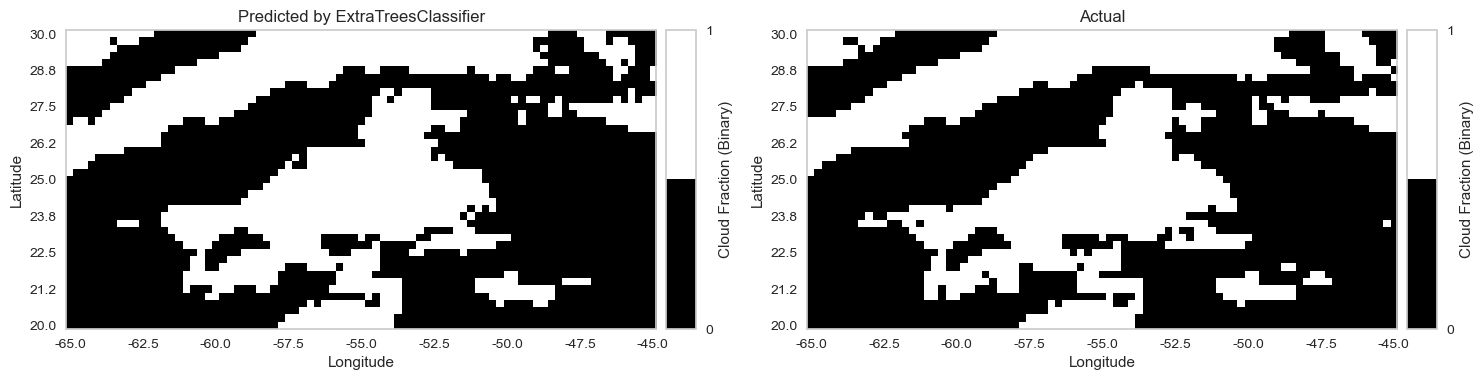

In [153]:
# plot the predicted class and the actual class of the data as subfigures
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
im1 = ax[0].imshow(df_pred_93, cmap=binary_cmap)
ax[0].grid(False)
ax[0].set_title('Predicted by ExtraTreesClassifier')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_yticklabels(np.append(np.linspace(20,30, 9),0)[::-1].round(1))
ax[0].set_xticklabels(np.append(np.linspace(-65,-45, 9).round(1)[::-1],0)[::-1])

im2 = ax[1].imshow(df_actual_93, cmap=binary_cmap)
ax[1].grid(False)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_yticklabels(np.append(np.linspace(20,30, 9),0)[::-1].round(1))
ax[1].set_xticklabels(np.append(np.linspace(-65,-45, 9).round(1)[::-1],0)[::-1])
ax[1].set_title('Actual')

# Add a colorbar for the predicted plot
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax1, ticks=[0, 1]).set_label("Cloud Fraction (Binary)")

# Add a colorbar for the predicted plot
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax1, ticks=[0, 1]).set_label("Cloud Fraction (Binary)")

plt.tight_layout()
plt.show()